In [2]:

%load_ext autoreload
%autoreload 2

In [3]:

import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

Current working directory:  c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from pathlib import Path
from scipy.stats import skew, kurtosis
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_102,
    FILE_PATH_CASE_102_HFM_T,
    FILE_PATH_CASE_102_HFM_T_OBS,
    FILE_PATH_CASE_102_HFM_Z,
    FILE_PATH_DRILLING_REPORT_LABELED_CASE_102,
)
from utils.constants.constants import conversion_factor_for_densities
from utils.utils.utils import (
    get_active_drilling_data,
    plot_flow_rpm_mud_dens_out,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    plot_with_warnings_down_hole_ecd,
    plot_with_warnings_pack_off_sensor_1_2,
    regression_for_asm_data_points

)
from utils.Classes.Classes.PackOffDetectionAlgorithm import PackOffDetectionAlgorithm
sns.set_theme()

In [5]:
# Loading files
sensor_data_case_102 = pd.read_pickle(FILE_PATH_CASE_102)
# Extracting the dates to consider
tstamp_min = '2020-08-17 12:00:00+00:00'
tstamp_max = '2020-08-21 13:00:00+00:00'
sensor_data_case_102 = sensor_data_case_102.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data_case_102 = sensor_data_case_102.iloc[1:] 
hfm_data_case_102_t = pd.read_pickle(FILE_PATH_CASE_102_HFM_T)
hfm_data_case_102_t_obs = pd.read_pickle(FILE_PATH_CASE_102_HFM_T_OBS)
hfm_data_case_102_z = pd.read_pickle(FILE_PATH_CASE_102_HFM_Z)
hfm_data_case_102_t.index = sensor_data_case_102.index
hfm_data_case_102_t_obs.index = sensor_data_case_102.index


[ 2551  2552  2553 ... 16233 16234 16235]


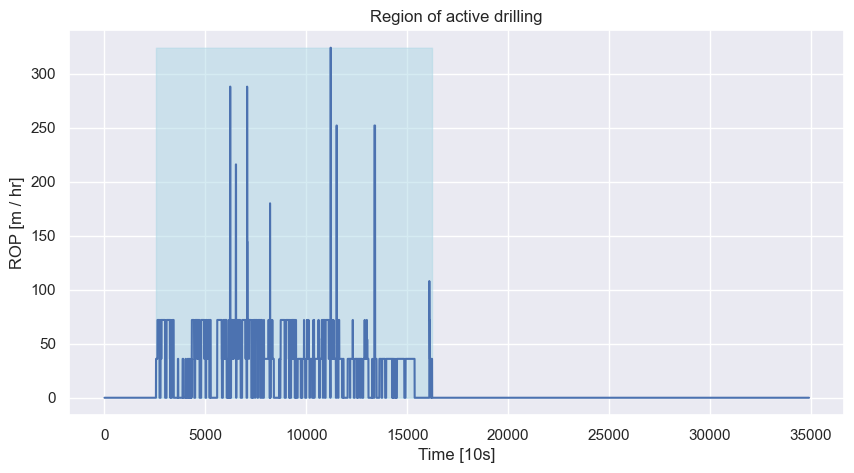

In [22]:
rop = sensor_data_case_102["ropav"].values*3600
x_values = np.where(rop > 0)
print(x_values[0])
x_values = np.arange(x_values[0][0], x_values[0][-1],1)
plt.figure(figsize=(10,5))
plt.title("Region of active drilling")
plt.xlabel("Time [10s]")
plt.ylabel("ROP [m / hr]")
plt.plot(rop)
plt.fill_between(x_values, np.min(rop), np.max(rop), color = "lightblue", alpha = 0.5)
plt.show()

In [7]:
# Threshold based on 100 us gpm value to ensure active drilling
threshold_value_flow = 0.0
df_sensor, df_simulated = get_active_drilling_data(df = sensor_data_case_102, sim_df=hfm_data_case_102_t_obs, include_rop_zeros=True)
# df_sensor = df_sensor[(df_sensor["MUD_FLOW_IN"]) > threshold_value_flow]
df_simulated = df_simulated.loc[df_sensor.index]
df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities
diff_flow = df_sensor["MUD_FLOW_IN"].diff()
diff_rpm = df_sensor["RPM_SURF"].diff()

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\1362911269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities


C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\3020830188.py:4: RuntimeWarning: invalid value encountered in divide
  inclination_1 = np.arccos(df_sensor["ASMTVD1-T"].diff().values / df_sensor["ASMDEP1-T"].diff().values) * 180 / np.pi
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\3020830188.py:4: RuntimeWarning: invalid value encountered in arccos
  inclination_1 = np.arccos(df_sensor["ASMTVD1-T"].diff().values / df_sensor["ASMDEP1-T"].diff().values) * 180 / np.pi
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\3020830188.py:5: RuntimeWarning: divide by zero encountered in divide
  inclination_2 = np.arccos(df_sensor["ASMTVD2-T"].diff().values / df_sensor["ASMDEP2-T"].diff().values) * 180 / np.pi
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\3020830188.py:5: RuntimeWarning: invalid value encountered in divide
  inclination_2 = np.arccos(df_sensor["ASMTVD2-T"].diff().values / df_sensor["ASMDEP2-T"].diff().values) * 180 / np.pi
C:\Users\thomaswi\AppData\Local\Tem

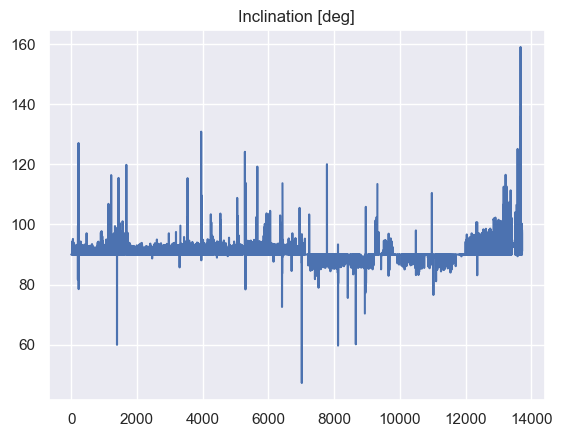

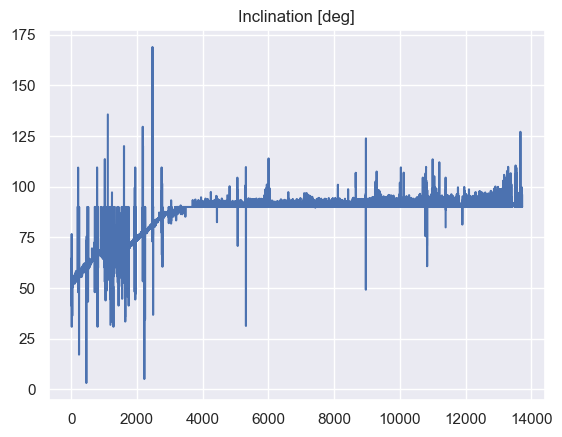

In [8]:
# plt.plot(df_sensor["ASMTVD1-T"].iloc[7258-20:7258 + 20].values)
# plt.plot(df_sensor["ASMTVD2-T"].iloc[7258-20:7258 + 20].values)
# plt.show()
inclination_1 = np.arccos(df_sensor["ASMTVD1-T"].diff().values / df_sensor["ASMDEP1-T"].diff().values) * 180 / np.pi
inclination_2 = np.arccos(df_sensor["ASMTVD2-T"].diff().values / df_sensor["ASMDEP2-T"].diff().values) * 180 / np.pi

plt.title("Inclination [deg]")
plt.plot(inclination_1, label = "ASM sensor 1")
plt.show()
plt.title("Inclination [deg]")
plt.plot(inclination_2, label = "ASM sensor 2")
plt.show()

In [9]:
# Used idx 735 and 5203 in the thesis

transients_idx = [734,4935,4975,5201,6923,7258,7638,7876,8295,9329,10555,11225,12845]

In [10]:
delta_hole_depth = df_sensor["DEPTH_HOLE"].iloc[7258] - df_sensor["DEPTH_HOLE"].iloc[0]
print(delta_hole_depth)
print(df_sensor["DEPTH_HOLE"].iloc[7258])
print(df_sensor["ASMDEP1-T"].iloc[7258])

815.06323242187
4602.134765625
4391.666666666667


In [11]:
hole_diameter = 0.2413
print('Volume of generated cuttings is: ',delta_hole_depth * np.pi * (hole_diameter / 2)**2,'m^3')

Volume of generated cuttings is:  37.27312688145031 m^3


In [12]:
ecd_values_to_analyse_botum_sensor = df_sensor["DH_PRESS_ECD"].iloc[7248:7268]
ecd_values_to_analyse_sensor_1 = df_sensor["ASMECD1-T"].iloc[7248:7268]
ecd_values_to_analyse_sensor_1_hfm = df_simulated["ecdAtPos2"].iloc[7248:7268]
ecd_values_to_analyse_sensor_2 = df_sensor["ASMECD2-T"].iloc[7248:7268]
ecd_values_to_analyse_sensor_2_hfm = df_simulated["ecdAtPos3"].iloc[7248:7268]
dist = df_sensor["ASMDEP1-T"].values - df_sensor["ASMDEP2-T"].values
flow = df_sensor["MUD_FLOW_IN"].iloc[7248:7268]
torque = df_sensor["TORQ"].iloc[7248:7268]
rps = df_sensor["RPM_SURF"].iloc[7248:7268] * 10 * 60
heat_loss_torque = torque * rps * np.pi * 2

Q = 0.04 # by visual inspection
TVD = 2738
g = 9.80
distance_between_sensors = 591 # m
print(print(heat_loss_torque))

TIME
2020-08-18 15:09:10+00:00    0.000000e+00
2020-08-18 15:09:20+00:00    0.000000e+00
2020-08-18 15:09:30+00:00    2.036266e+07
2020-08-18 15:09:40+00:00    0.000000e+00
2020-08-18 15:09:50+00:00    0.000000e+00
2020-08-18 15:10:00+00:00    1.101419e+07
2020-08-18 15:10:10+00:00    1.036021e+08
2020-08-18 15:10:20+00:00    3.456889e+08
2020-08-18 15:10:30+00:00    6.207834e+08
2020-08-18 15:10:40+00:00    9.226128e+08
2020-08-18 15:10:50+00:00    1.281054e+09
2020-08-18 15:11:00+00:00    1.423685e+09
2020-08-18 15:11:10+00:00    1.365673e+09
2020-08-18 15:11:20+00:00    1.344970e+09
2020-08-18 15:11:30+00:00    1.380419e+09
2020-08-18 15:11:40+00:00    1.487493e+09
2020-08-18 15:11:50+00:00    1.546703e+09
2020-08-18 15:12:00+00:00    1.470637e+09
2020-08-18 15:12:10+00:00    1.473348e+09
2020-08-18 15:12:20+00:00    1.514586e+09
dtype: float64
None


In [13]:
print("Values to consider: ", ecd_values_to_analyse_sensor_1.values)
print("Values to consider: ", ecd_values_to_analyse_sensor_1_hfm.values)

Values to consider:  [1.35011133 1.3483383  1.3508538  1.35033047 1.35070373 1.35100857
 1.34930517 1.3495549  1.35225552 1.35683569 1.36048784 1.36812484
 1.37223661 1.3769023  1.37264216 1.37007162 1.36897669 1.36946407
 1.36956074 1.36967766]
Values to consider:  [1.3513 1.35   1.3518 1.3527 1.3533 1.3535 1.3522 1.3522 1.3535 1.3549
 1.3568 1.3586 1.3604 1.3614 1.3606 1.3601 1.3594 1.359  1.3589 1.3589]


<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
C:\Users\thomaswi\AppData\Local\Temp\ipykernel_24180\3884011752.py:27: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel("$\dot{W}$ [$\mathrm{J}/s$]",fontsize = 20)


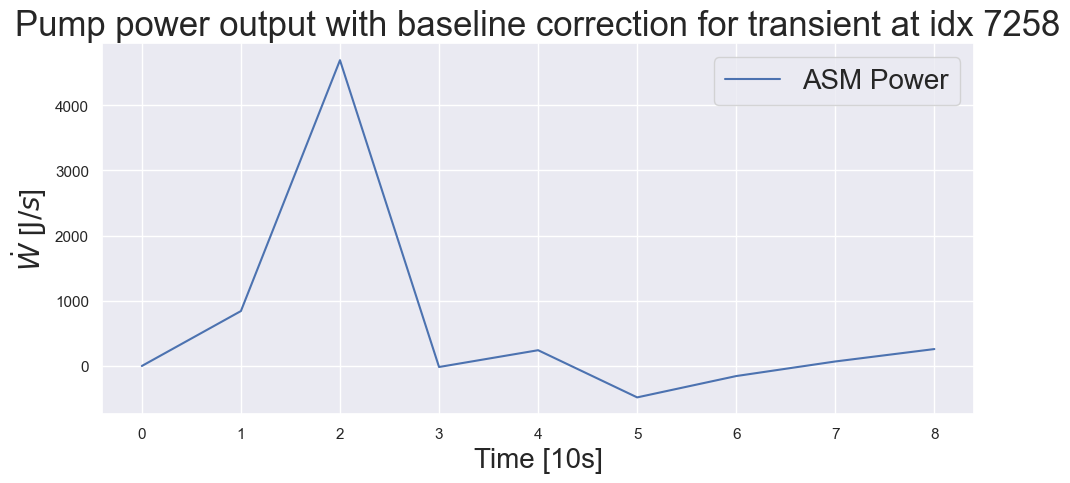

In [15]:
fig, ax = plt.subplots(1, figsize = (10,5))
# ax[0].set_title("Transient used to estimate amount of entrained cuttings")
# ax[0].plot(ecd_values_to_analyse_sensor_1.values, label = "ASM Sensor 1")
# ax[0].plot(ecd_values_to_analyse_sensor_1_hfm.values, label = "HFM Sensor 1")
# ax[0].plot(ecd_values_to_analyse_sensor_2.values, label = "ASM Sensor 2")
# ax[0].plot(ecd_values_to_analyse_sensor_2_hfm.values, label = "HFM Sensor 2")
# # ax[0].plot(ecd_values_to_analyse_botum_sensor.values, label = "ECD at bottom")
# ax[0].set_xlabel("Time [10s]")
# ax[0].set_ylabel("$ECD$ [$\mathrm{gcm}^{-3}$]")
# ax[0].legend()
x1 = np.linspace(0,1,100)
x2 = np.linspace(1,1.8,100)
y_1 = 4000 * x1
y_2 = - 5000 * x2 + 9000
# plt.plot(x2,y_2)
# plt.show()
# plt.plot(y_2)
pressure_diff_asm = ecd_values_to_analyse_sensor_1 - ecd_values_to_analyse_sensor_2
pressure_diff_hfm = ecd_values_to_analyse_sensor_1_hfm - ecd_values_to_analyse_sensor_2_hfm
effect_asm = flow * pressure_diff_asm * TVD * conversion_factor_for_densities*g
corrected_effect_asm = effect_asm.iloc[11:] - effect_asm.iloc[11]
# effect_hfm = flow * pressure_diff_hfm * TVD * conversion_factor_for_densities*g
ax.set_title("Pump power output with baseline correction for transient at idx 7258",fontsize = 25)
ax.plot(corrected_effect_asm.values, label = "ASM Power")
# ax.plot(effect_hfm.values, label = "HFM Power")
ax.set_xlabel("Time [10s]",fontsize = 20)
ax.set_ylabel("$\dot{W}$ [$\mathrm{J}/s$]",fontsize = 20)
# ax.fill_between(x1, 0, y_1, where = (y_1 > 0) & (y_1 < 4000), alpha  = 0.5, color = "C1")
# ax.fill_between(x2, y_2, 0, where = (y_2 < 4000) & (y_2 > 0), alpha  = 0.5, color = "C1")
ax.legend(fontsize = 20)
# derivative_pressure_asm_diff = pressure_diff_asm.diff()
# derivative_pressure_hfm_diff = pressure_diff_hfm.diff()
# ax[2].set_title("Derrivative of difference between sensors")
# ax[2].plot(derivative_pressure_asm_diff.values, label = "ASM")
# ax[2].plot(derivative_pressure_hfm_diff.values, label = "HFM")
# ax[2].set_xlabel("Time [10s]")
# ax[2].set_ylabel("Time derivative of $ECD$ [$\mathrm{gcm}^{-3} \mathrm{t}^{-1}$]")
# ax[2].legend()
plt.tight_layout()
plt.show()

In [21]:
# diff_ecd_1 = ecd_values_to_analyse_sensor_1.iloc[13] - ecd_values_to_analyse_sensor_1_hfm.iloc[13] - (ecd_values_to_analyse_sensor_1.iloc[16] - ecd_values_to_analyse_sensor_1_hfm.iloc[16])
# diff_ecd_2 = ecd_values_to_analyse_sensor_2.iloc[13] - ecd_values_to_analyse_sensor_2_hfm.iloc[13] - (ecd_values_to_analyse_sensor_2.iloc[16] - ecd_values_to_analyse_sensor_2_hfm.iloc[16])
# diff_ecd = pressure_diff_asm.iloc[13] - pressure_diff_asm.iloc[11] - (pressure_diff_hfm.iloc[13] - pressure_diff_hfm.iloc[11])
# diff_ecd_integrated = np.sum([derivative_pressure_asm_diff.iloc[idx] for idx in range(11,14)])
# print(diff_ecd_integrated)
# print(diff_ecd_1 - diff_ecd_2, diff_ecd, diff_ecd_integrated)
# delta_p = diff_ecd_integrated * TVD * g * conversion_factor_for_densities
# delta_t = 0.003 # duration of energy transfer infered from experiments
# average_velocity_in_annulus = Q / cross_sectional_area
# # average_velocity_in_annulus = 1.8
# print("The average velocity in the annulus is: ", average_velocity_in_annulus)
# print("The pressure differences between the sensors are:", delta_p)
# # d_energy = Q * delta_p * delta_t * 0.7
# d_energy = Q * delta_p * delta_t 
# print("The energy associated with this change in pressure is: ", d_energy)
# # Different methods. One uses conservation of energy the other uses the formula from Bjørnars paper
# mass_entrained = 2 * d_energy / average_velocity_in_annulus**2
# # mass_entrained = delta_p * cross_sectional_area / (average_velocity_in_annulus)
# print("The mass of entrained cuttings between sensor 1 and 2 assuming no heat loss is: ", mass_entrained)
# V_c = mass_entrained / 2200 # estimate of density of limestone
# print("The volume of entrained cuttings is: ", V_c, 'm^3')
# height_of_bed = np.sqrt(2*V_c / (distance_between_sensors*np.pi))
# bed_height_rel = height_of_bed / hole_diameter
# print("The height of this bed relative to the diameter is: ", bed_height_rel)
def integrate_data_values(values, DT):

    """ 
    Function integrates a list assuming that the points in the list are linearly interpolated....

    """

    areas =  [DT * (values[i] + values[i-1] / 2) for i in range(1,len(values))]
    integral = sum(areas)
    return integral

drillstring_diameter = 0.1397
cross_sectional_area = np.pi * ((hole_diameter/2)**2 - (drillstring_diameter / 2)**2)
# print(cross_sectional_area)
# print(effect_asm.iloc[10:15])
W = integrate_data_values(corrected_effect_asm.iloc[:4].values,10)
alternative_W = corrected_effect_asm.iloc[1]*5 + corrected_effect_asm.iloc[1] * 10 + (corrected_effect_asm.iloc[2] - corrected_effect_asm.iloc[1]) * 5 + corrected_effect_asm.iloc[2] * 5
W = alternative_W
print("The total work performed by the pump during this transient is: ", W)
print("Total alternative work performed by the pump during transient is: ", alternative_W)
print(" ")
v = Q / cross_sectional_area
print(v)
# print(" ")
# W_corrected = W - W_hfm
# print("The energy corrected for the difference in the HFM is: ", W_corrected)
# print(" ")
# m_c_corrected = 2 * W_corrected / v**2
# print("This translates to a mass of: ",m_c_corrected)
# print(" ")
# W_corrected_baseline_difference = W_corrected + (-effect_asm.values[1] + effect_hfm.values[1])* 10 * len(effect_asm.values[10:15]-1)
# print(" ")
# print("Corrected for baseline power output that is not due to cuttings transport we obtain: ", W_corrected_baseline_difference)
# print(" ")
# m_c_corrected_baseline_difference = 2 * W_corrected_baseline_difference / v**2
# print("This translates to a mass of: ",m_c_corrected_baseline_difference)
# print(" ")

# print("Assuming between 20 and 40 percent viscous dissipation we get for 20: ", m_c_corrected_baseline_difference*0.8, "kg and for 40: ", m_c_corrected_baseline_difference*0.6, " kg")
# print("Relative volume of annulus between sensors: ", (m_c_corrected_baseline_difference / 2200) /( cross_sectional_area * 591))

# print(m_c_corrected_baseline_difference / 2200)
# print(cross_sectional_area * 591)

porosity_1 = 0.5
porosity_2 = 0.15
porosity_3 = 0.48
rho_c = 2623
rho_f = 1300

V_c = 2 * W / (rho_c * v**2)
m_c = V_c * rho_c
print("Assuming all the energy gets transfered to the cuttings this translates to a volume of: ", V_c)
print("Assuming all the energy gets transfered to the cuttings this translates to a mass of: ", m_c)
# V_bed1 = (2 * W_corrected_baseline_difference) / (v**2 * (porosity_1 * rho_f + (1-porosity_1)*rho_c))
# V_bed2 = (2 * W_corrected_baseline_difference) / (v**2 * (porosity_2 * rho_f + (1-porosity_2)*rho_c))
# print("The volume of the bed with 10 and 15 percent porosity is: ", V_bed1, " and ",V_bed2," m^3")
# print("This translated to a mass of cuttings as: ", rho_c * V_bed1 *(1-porosity_1))
# print(" ")
# print(" ")
# print("Doing another calculation ")
# new_work = integrate_data_values(effect_asm.values[12:15],10)
# new_work = new_work - effect_asm.iloc[14]*20
# print(new_work)
V_bed1 = (2 * W) / (v**2 * (porosity_1 * rho_f + (1-porosity_1)*rho_c))
V_bed2 = (2 * W) / (v**2 * (porosity_2 * rho_f + (1-porosity_2)*rho_c))
V_bed3 = (2 * W) / (v**2 * (porosity_3 * rho_f + (1-porosity_3)*rho_c))

print(V_bed1, V_bed2, V_bed3)

The total work performed by the pump during this transient is:  55353.66303271585
Total alternative work performed by the pump during transient is:  55353.66303271585
 
1.31568349425999
Assuming all the energy gets transfered to the cuttings this translates to a volume of:  24.38233073819798
Assuming all the energy gets transfered to the cuttings this translates to a mass of:  63954.8535262933
25.677461567548598 26.378030366993176 32.17109676567602


In [16]:
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme()
transients = []
ecd_1_segments = []
ecd_2_segments = []
ecd_1_segments_sim = []
ecd_2_segments_sim = []
flow_segment = []
hookload_segment = []
rpm_segment = []
torque_segment = []
bit_depth_segment = []
hole_depth_segment = []
window_size = 30
for index in transients_idx:
    transients.append([df_sensor.index[index], index])
    ecd_1_segments.append(df_sensor["ASMECD1-T"].iloc[index - window_size:index + window_size].values)
    ecd_2_segments.append(df_sensor["ASMECD2-T"].iloc[index - window_size:index + window_size].values)
    ecd_1_segments_sim.append(df_simulated["ecdAtPos2"].iloc[index - window_size:index + window_size].values)
    ecd_2_segments_sim.append(df_simulated["ecdAtPos3"].iloc[index - window_size:index + window_size].values)
    flow_segment.append(df_sensor["flowinav"].iloc[index - window_size:index + window_size].values)
    hookload_segment.append(df_sensor["HKLDAV"].iloc[index - window_size:index + window_size].values)
    rpm_segment.append(10*df_sensor["rpmav"].iloc[index - window_size:index + window_size].values)
    torque_segment.append(df_sensor["TORQ"].iloc[index - window_size:index + window_size].values)
    bit_depth_segment.append(df_sensor["DEPTH_BIT"].iloc[index - window_size:index + window_size].values)
    hole_depth_segment.append(df_sensor["DEPTH_HOLE"].iloc[index - window_size:index + window_size].values)

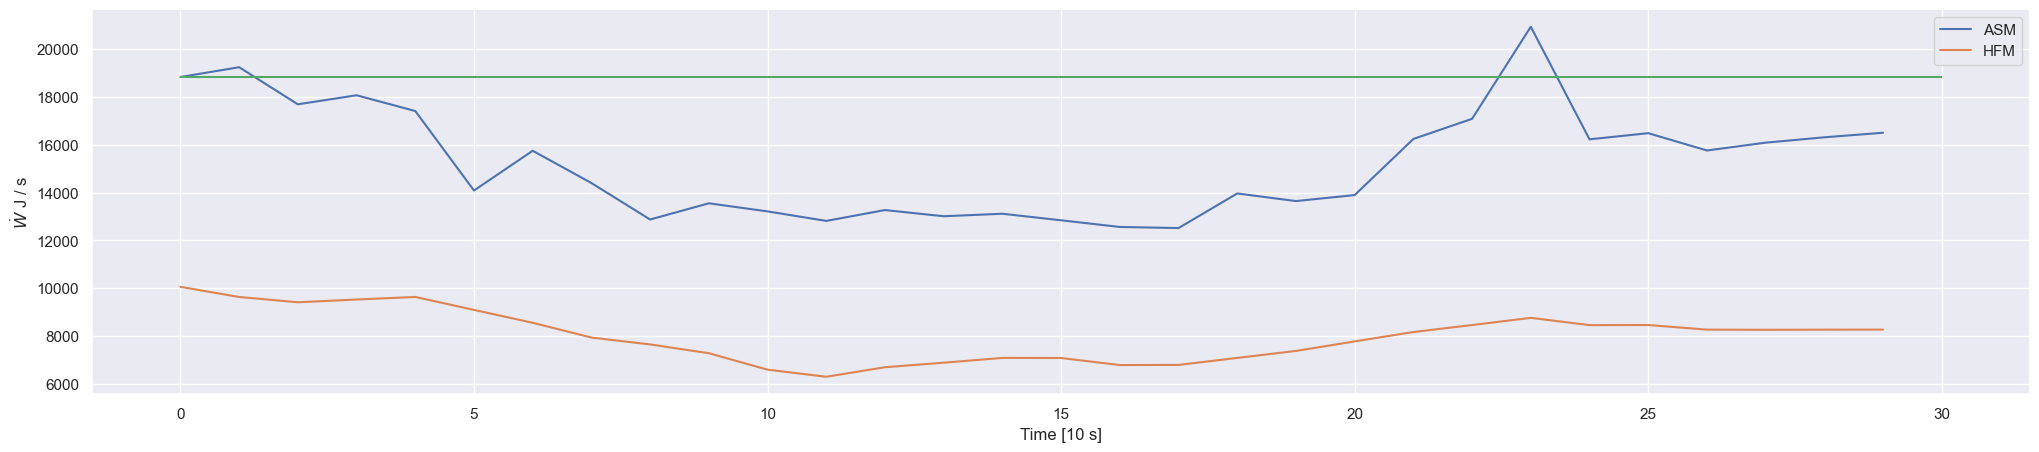

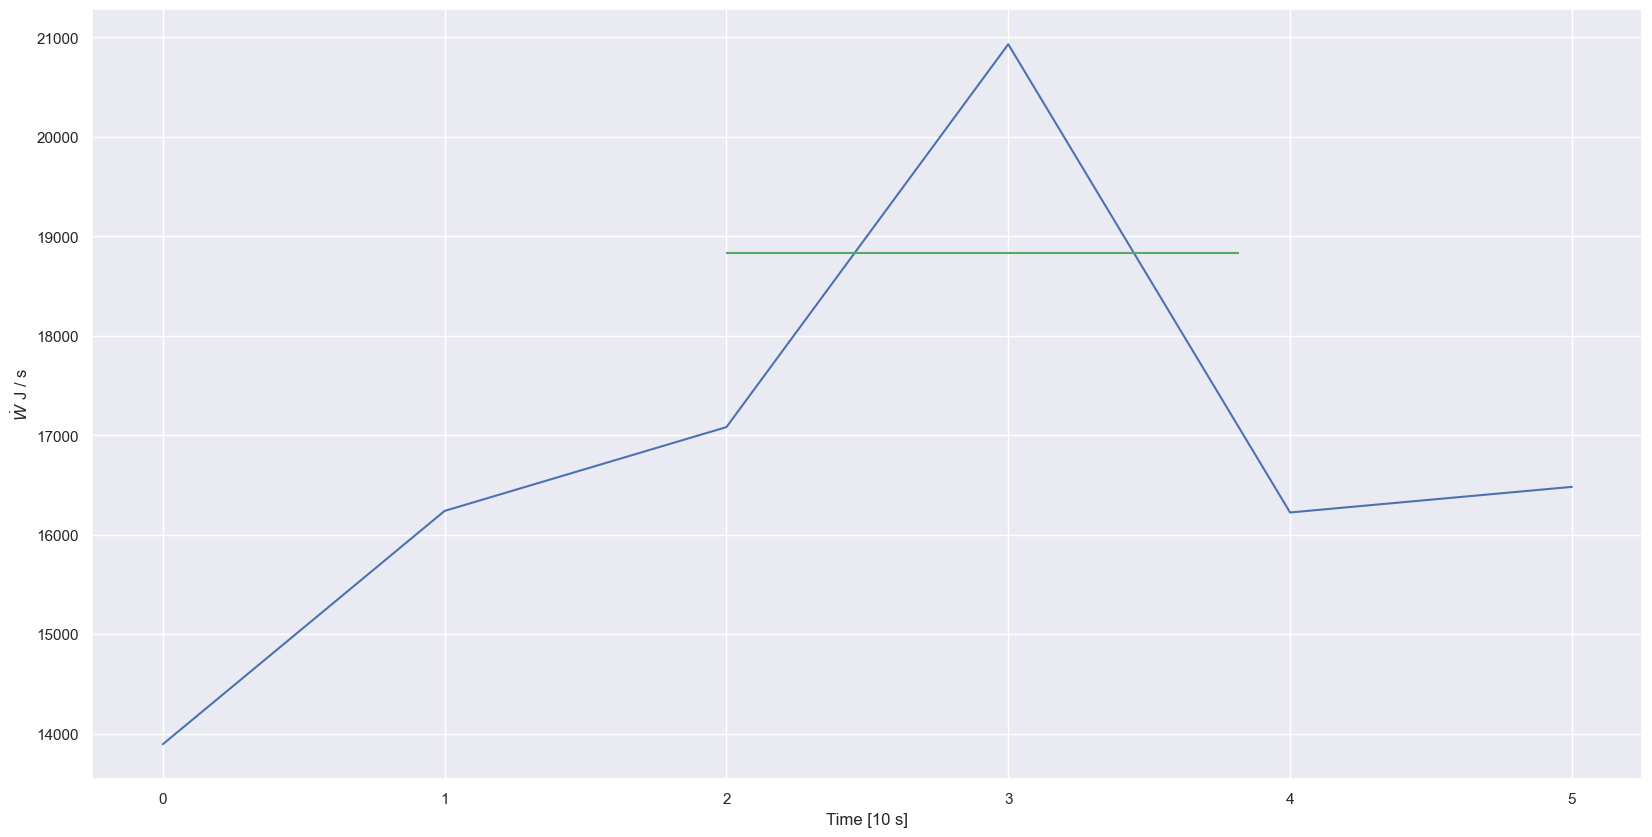

In [17]:
power_output_sensor = df_sensor["ASMECD1-T"].iloc[7238:7268].values*TVD*g*df_sensor["MUD_FLOW_IN"].iloc[7238:7268].values*conversion_factor_for_densities - df_sensor["ASMECD2-T"].iloc[7238:7268].values*TVD*g*df_sensor["MUD_FLOW_IN"].iloc[7238:7268].values*conversion_factor_for_densities
power_output_simulated = df_simulated["ecdAtPos2"].iloc[7238:7268].values*TVD*g* df_sensor["MUD_FLOW_IN"].iloc[7238:7268].values*conversion_factor_for_densities- df_simulated["ecdAtPos3"].iloc[7238:7268].values*TVD*g*df_sensor["MUD_FLOW_IN"].iloc[7238:7268].values*conversion_factor_for_densities
plt.figure(figsize=(25,5))
plt.plot(power_output_sensor,label = "ASM")
plt.plot(power_output_simulated, label ="HFM")
plt.hlines(power_output_sensor[0], 0, 30, colors="C2")
plt.ylabel(r"$\dot{W}$ J / s")
plt.xlabel("Time [10 s]")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
power_output_sensor_for_new_work =power_output_sensor[20:26] 
plt.plot(power_output_sensor_for_new_work, label = "ASM")
plt.hlines(power_output_sensor[0], 2, 3.82, color = "C2") 
plt.ylabel(r"$\dot{W}$ J / s")
plt.xlabel("Time [10 s]")
plt.show()

change_in_power_output = power_output_sensor[0]-power_output_sensor[24]

In [18]:
idx = 7638
sensor_1_depth = df_sensor["ASMDEP1-T"].iloc[idx]
sensor_2_depth = df_sensor["ASMDEP2-T"].iloc[idx]

In [19]:
transport_times_dict = {734 : [246,310,431, 494], 4935 : [246, 310, 484,548], 5201 : [246,310,484,547], 6923 : [265, 329,521,584],7258: [246,310,484,548], 7638 : [242,306,484,548]}


In [20]:
for idx in transport_times_dict:
    print("Measured depth at ASM sensor position 1", df_sensor["ASMDEP1-T"].iloc[idx], "Meassured depth at ASM sensor position 2", df_sensor["ASMDEP2-T"].iloc[idx], " for transient at idx", idx)

Measured depth at ASM sensor position 1 3672.29802 Meassured depth at ASM sensor position 2 3080.8280600000003  for transient at idx 734
Measured depth at ASM sensor position 1 4138.243466666667 Meassured depth at ASM sensor position 2 3546.7650000000003  for transient at idx 4935
Measured depth at ASM sensor position 1 4173.258749999999 Meassured depth at ASM sensor position 2 3581.8024875  for transient at idx 5201
Measured depth at ASM sensor position 1 4369.1802 Meassured depth at ASM sensor position 2 3777.7  for transient at idx 6923
Measured depth at ASM sensor position 1 4391.666666666667 Meassured depth at ASM sensor position 2 3800.19994  for transient at idx 7258
Measured depth at ASM sensor position 1 4432.756125 Meassured depth at ASM sensor position 2 3841.2757142857145  for transient at idx 7638


In [21]:
distance_to_liner = sensor_1_depth - 3468
time_to_liner =  distance_to_liner / v
time_to_vertical = 1691
time_from_vertical = 2283
time_from_vertical_large = time_from_vertical *   0.83 / (0.93 - 0.28)
cease_in_flow = 140
time_to_top = time_to_liner + cease_in_flow + time_to_vertical + time_from_vertical 
time_to_top_large = time_to_top + time_from_vertical_large - time_from_vertical
print(time_to_top, time_to_top_large)

4847.273716063931 5479.489100679315


In [22]:
print(time_from_vertical+cease_in_flow, time_from_vertical_large+cease_in_flow)

2423 3055.215384615384


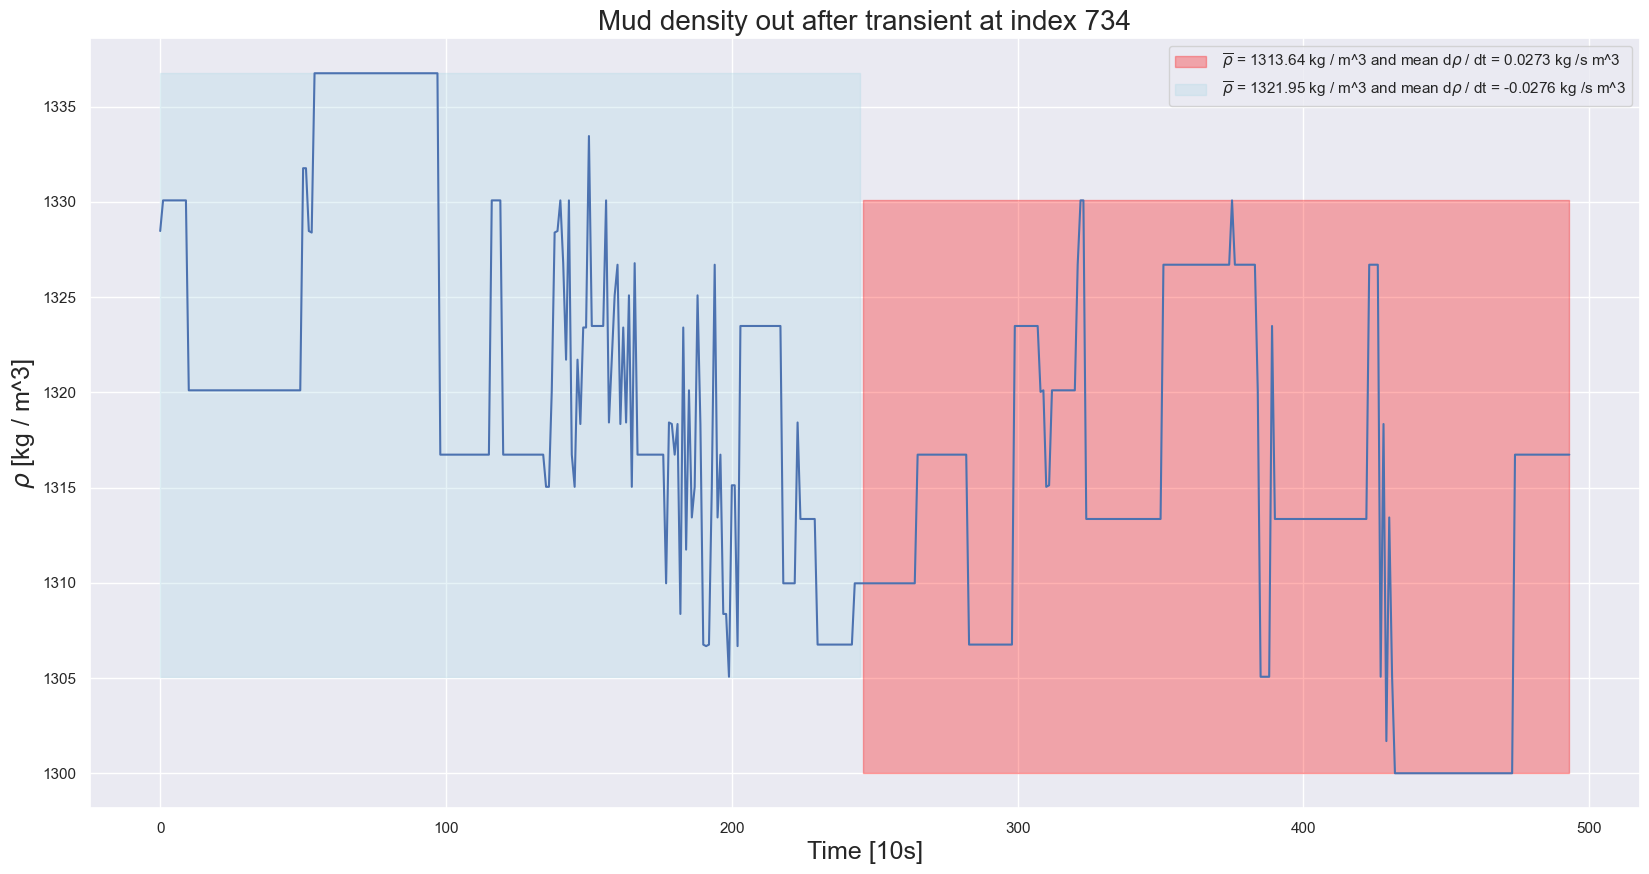

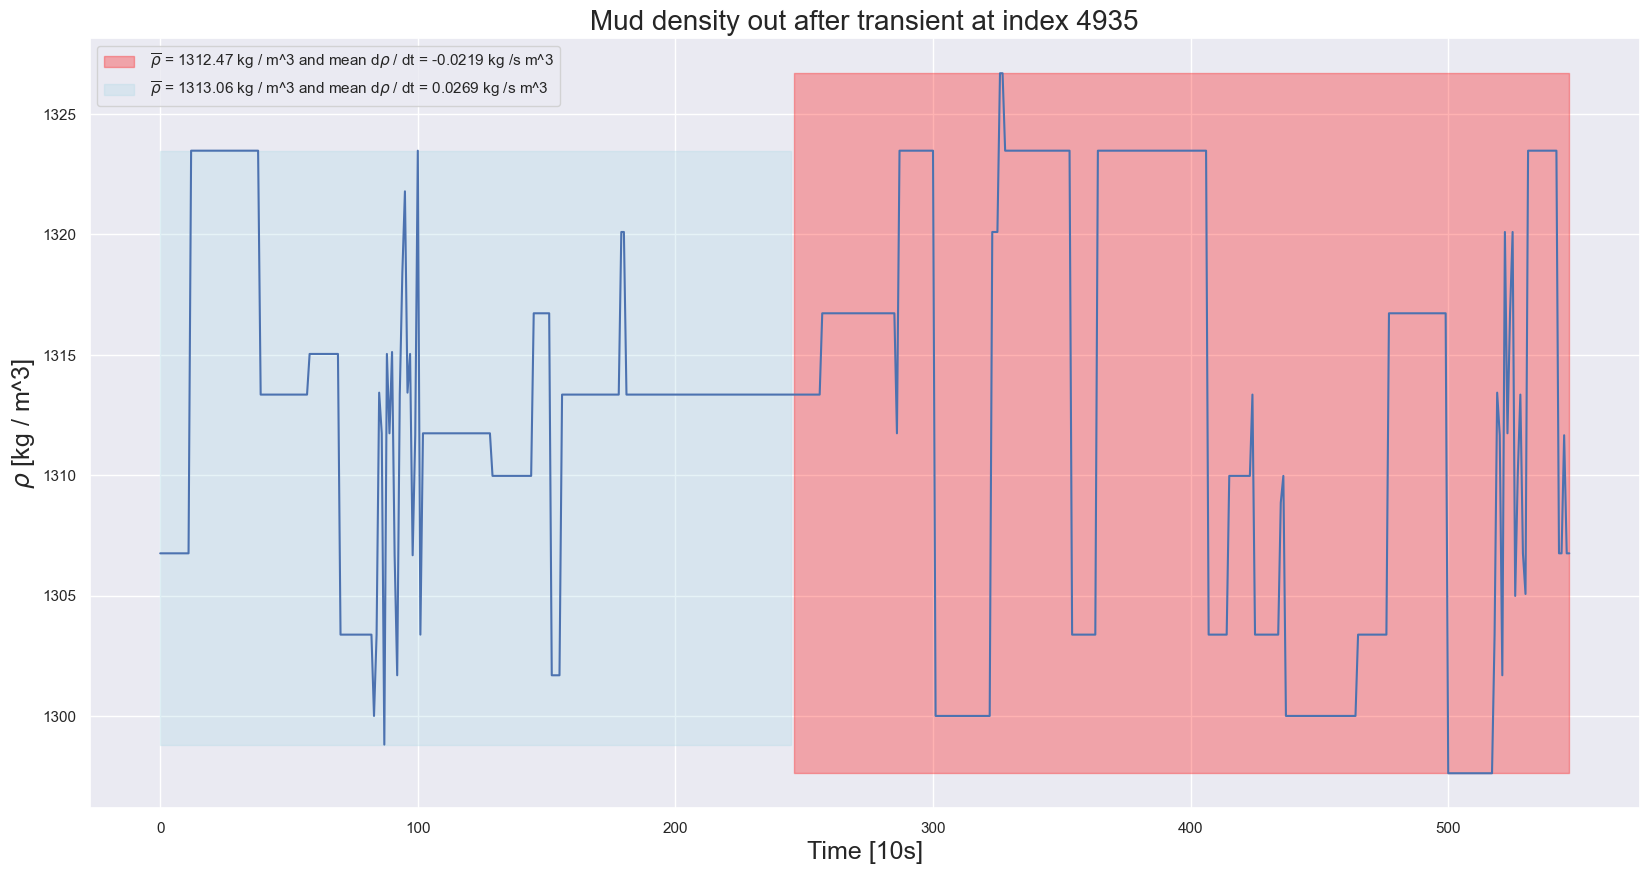

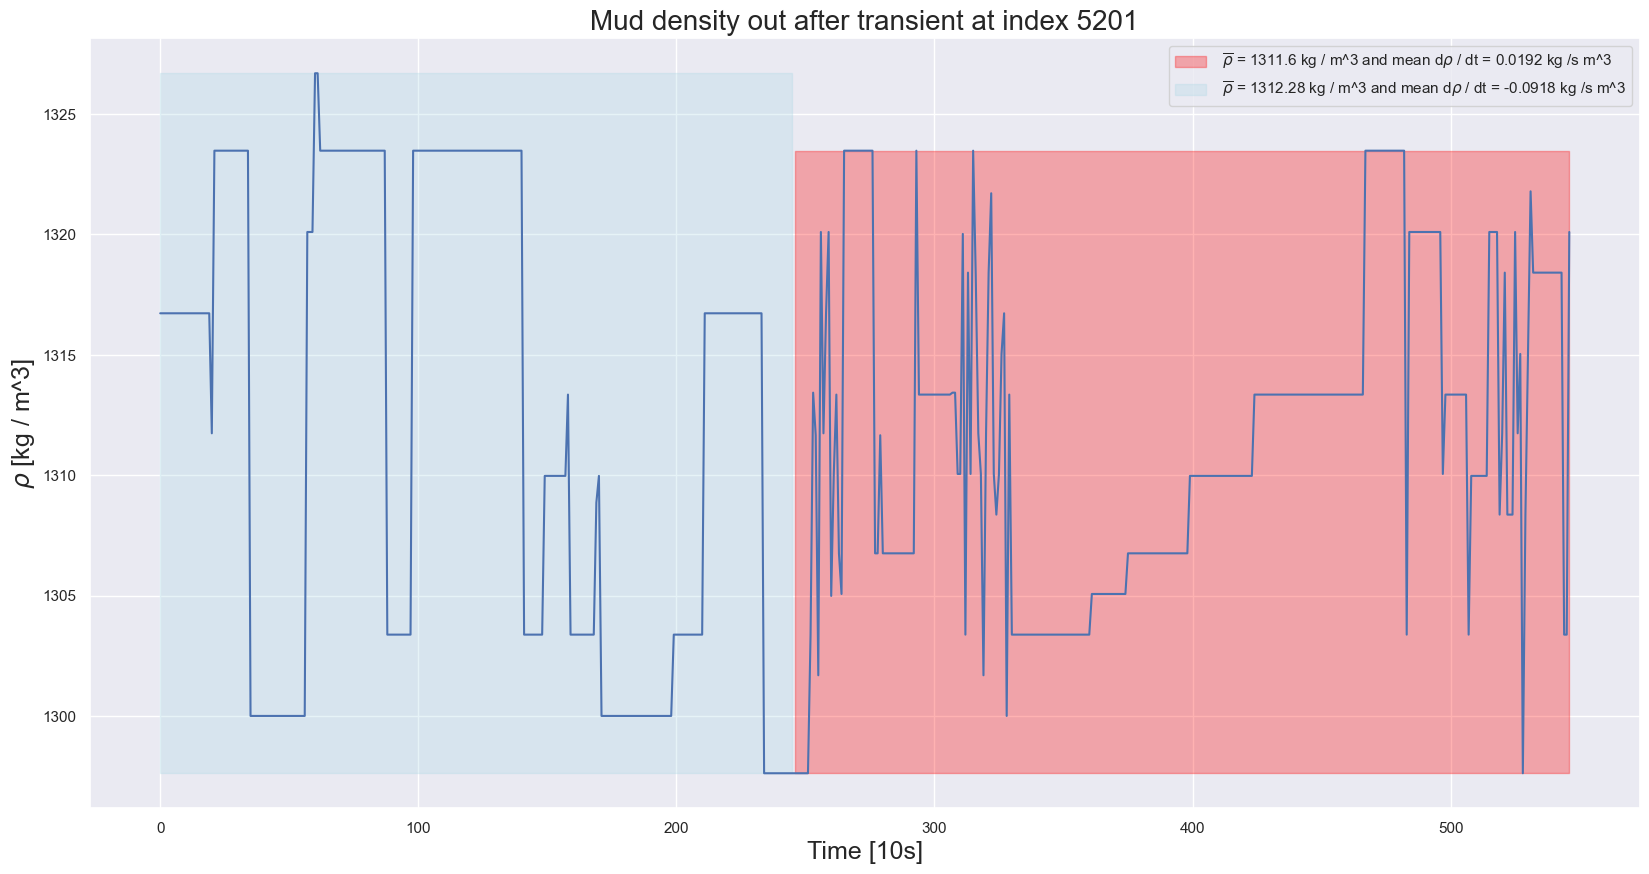

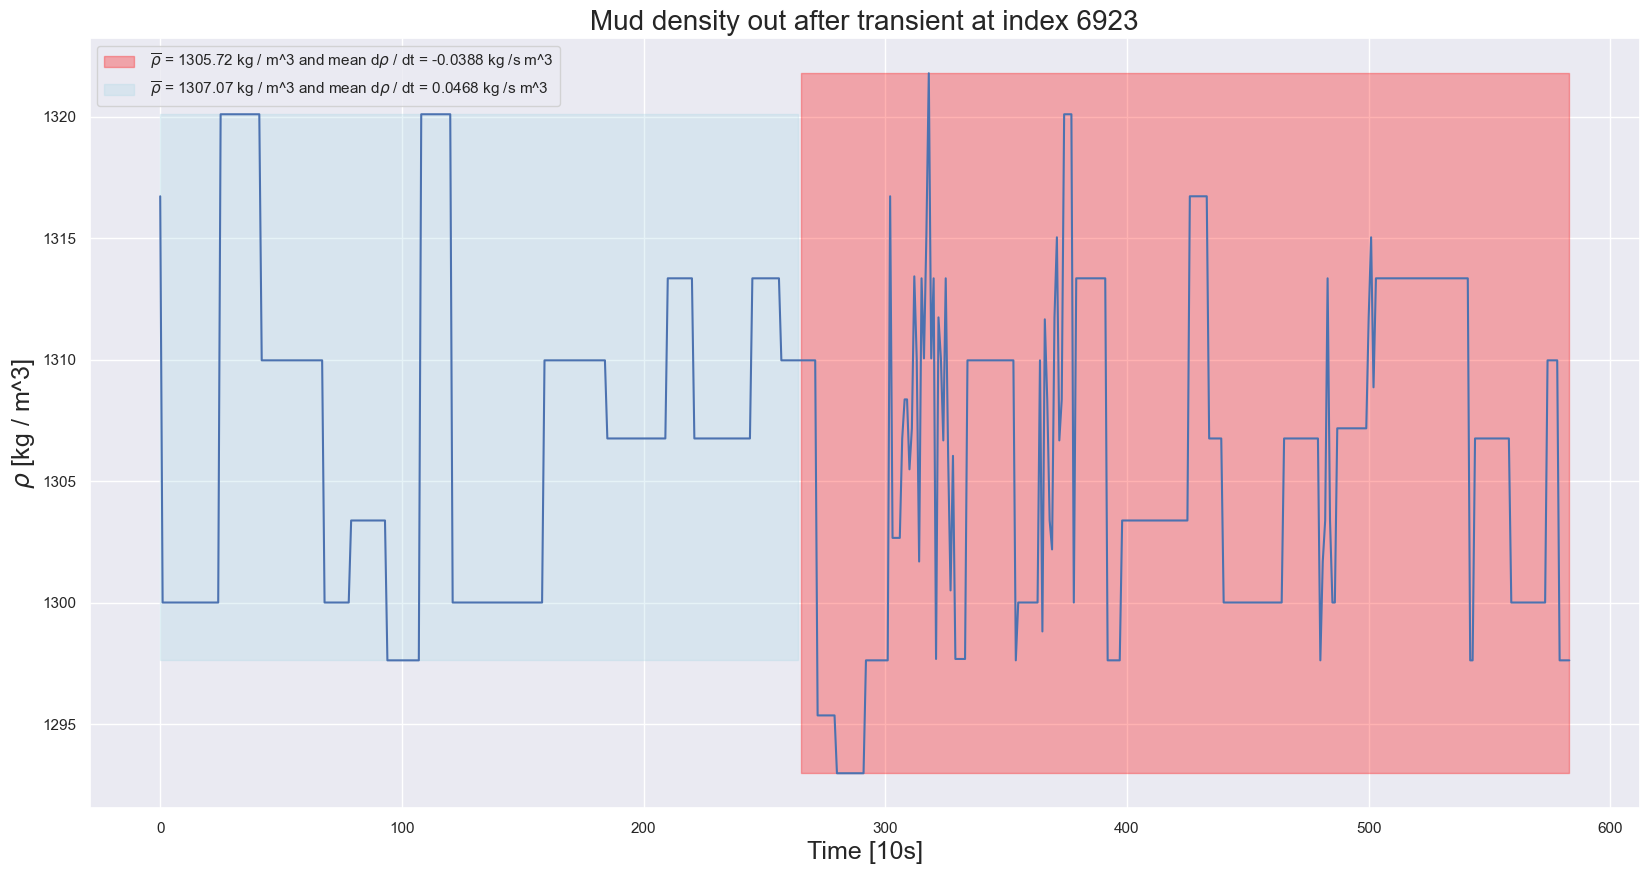

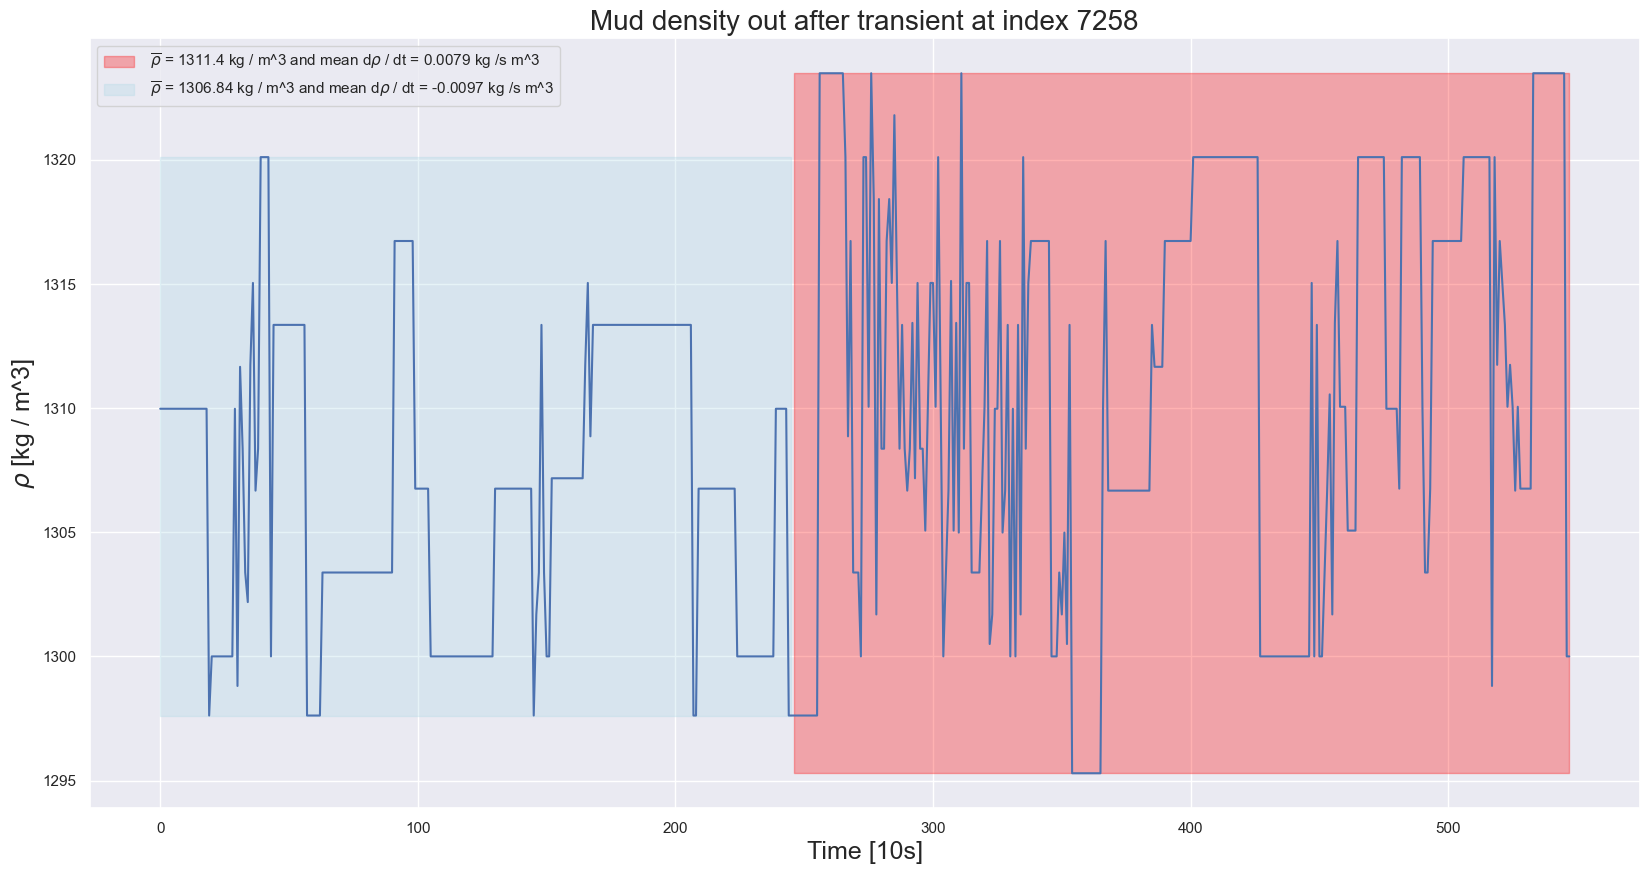

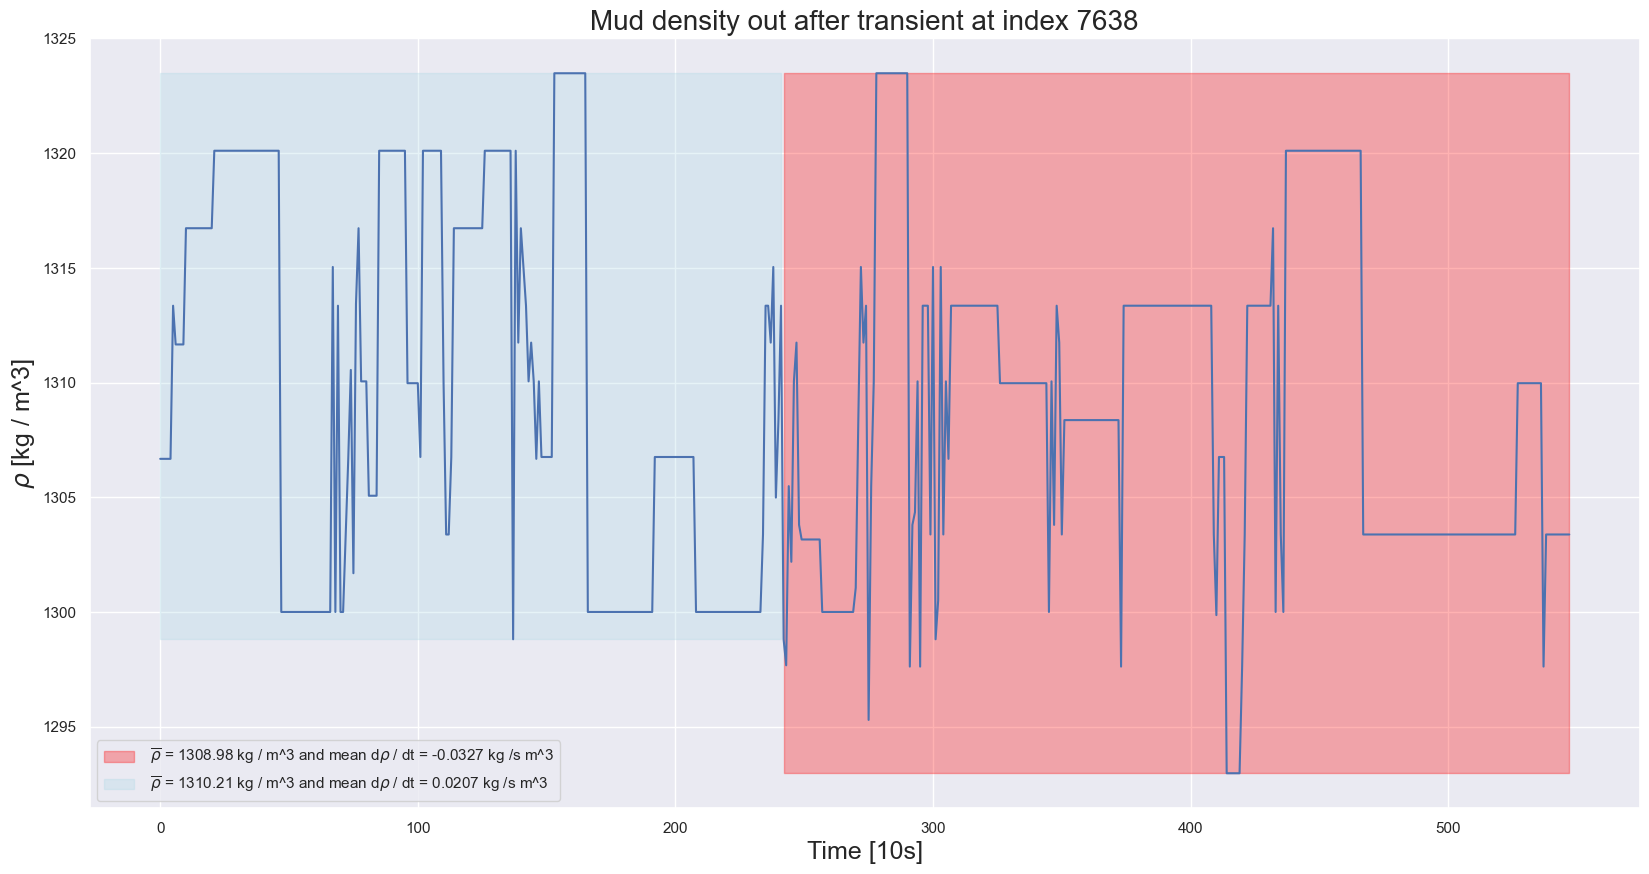

In [23]:
for idx, transport_times in transport_times_dict.items():

    plot_flow_rpm_mud_dens_out(df_sensor,idx,*transport_times)


# Performing a statistical test to see if the mean of the density after tranients are significant

In [24]:
# from scipy import stats
# horizon_for_correlation = 400
# start_time = 240
# indices_to_evaluate_mass_densities = [734,4935,6923]
# stat_and_p_values = [stats.shapiro(df_sensor["MUD_DENS_OUT"].iloc[indice+start_time:indice + horizon_for_correlation + start_time].values) for indice in indices_to_evaluate_mass_densities]
# alpha = 0.05
# for element in stat_and_p_values:
#     p_value = element[1]
#     if p_value > alpha:
#         print("Data is not normally distributed")
#     else:
#         print("Data is normally distributed")


In [25]:
# mean_densities = [np.mean(density) for density in [df_sensor["MUD_DENS_OUT"].iloc[indice+start_time:indice+horizon_for_correlation + start_time].values for indice in indices_to_evaluate_mass_densities]]
# mean_densities_at_transients =[np.mean(density)for density in [df_sensor["MUD_DENS_OUT"].iloc[indice:indice+ start_time].values for indice in indices_to_evaluate_mass_densities]]
# print(mean_densities)
# densities = [density for density in [df_sensor["MUD_DENS_OUT"].iloc[indice+start_time:indice+horizon_for_correlation + start_time].values for indice in indices_to_evaluate_mass_densities]]
# print(mean_densities_at_transients)

Cool. There is a difference in mean output density. We now need to see if this difference is statistically significant.

In [26]:
# stat_and_p_values_test_1 = [stats.ttest_ind(densities[0], densities[2],alternative="greater")]
# stat_and_p_values_test_2 = [stats.ttest_ind(densities[1], densities[2],alternative="greater")]
# for element_1, element_2 in zip(stat_and_p_values_test_1,stat_and_p_values_test_2):
#     p_value_1 = element_1[1]
#     p_value_2 = element_2[1]
    
#     if p_value_1 < 0.05:
#         print("The difference in mean between the first transient and the last is significant")
#     if p_value_2 < 0.05:
#         print("The difference in mean between the second transient and the last is significant")
#     if p_value_2 and p_value_1 > 0.05:
#         print("The differences in mean are not statistically significant for either of the transients")

In [27]:
# for element_1, element_2 in zip(stat_and_p_values_test_1,stat_and_p_values_test_2):
#     print(element_1[0], element_1[1])
#     print(element_2[0], element_2[1])

In [28]:
lower_bound = 500
upper_bound = 8200
x_values = np.arange(lower_bound,upper_bound,1)

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_3788\2132347418.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


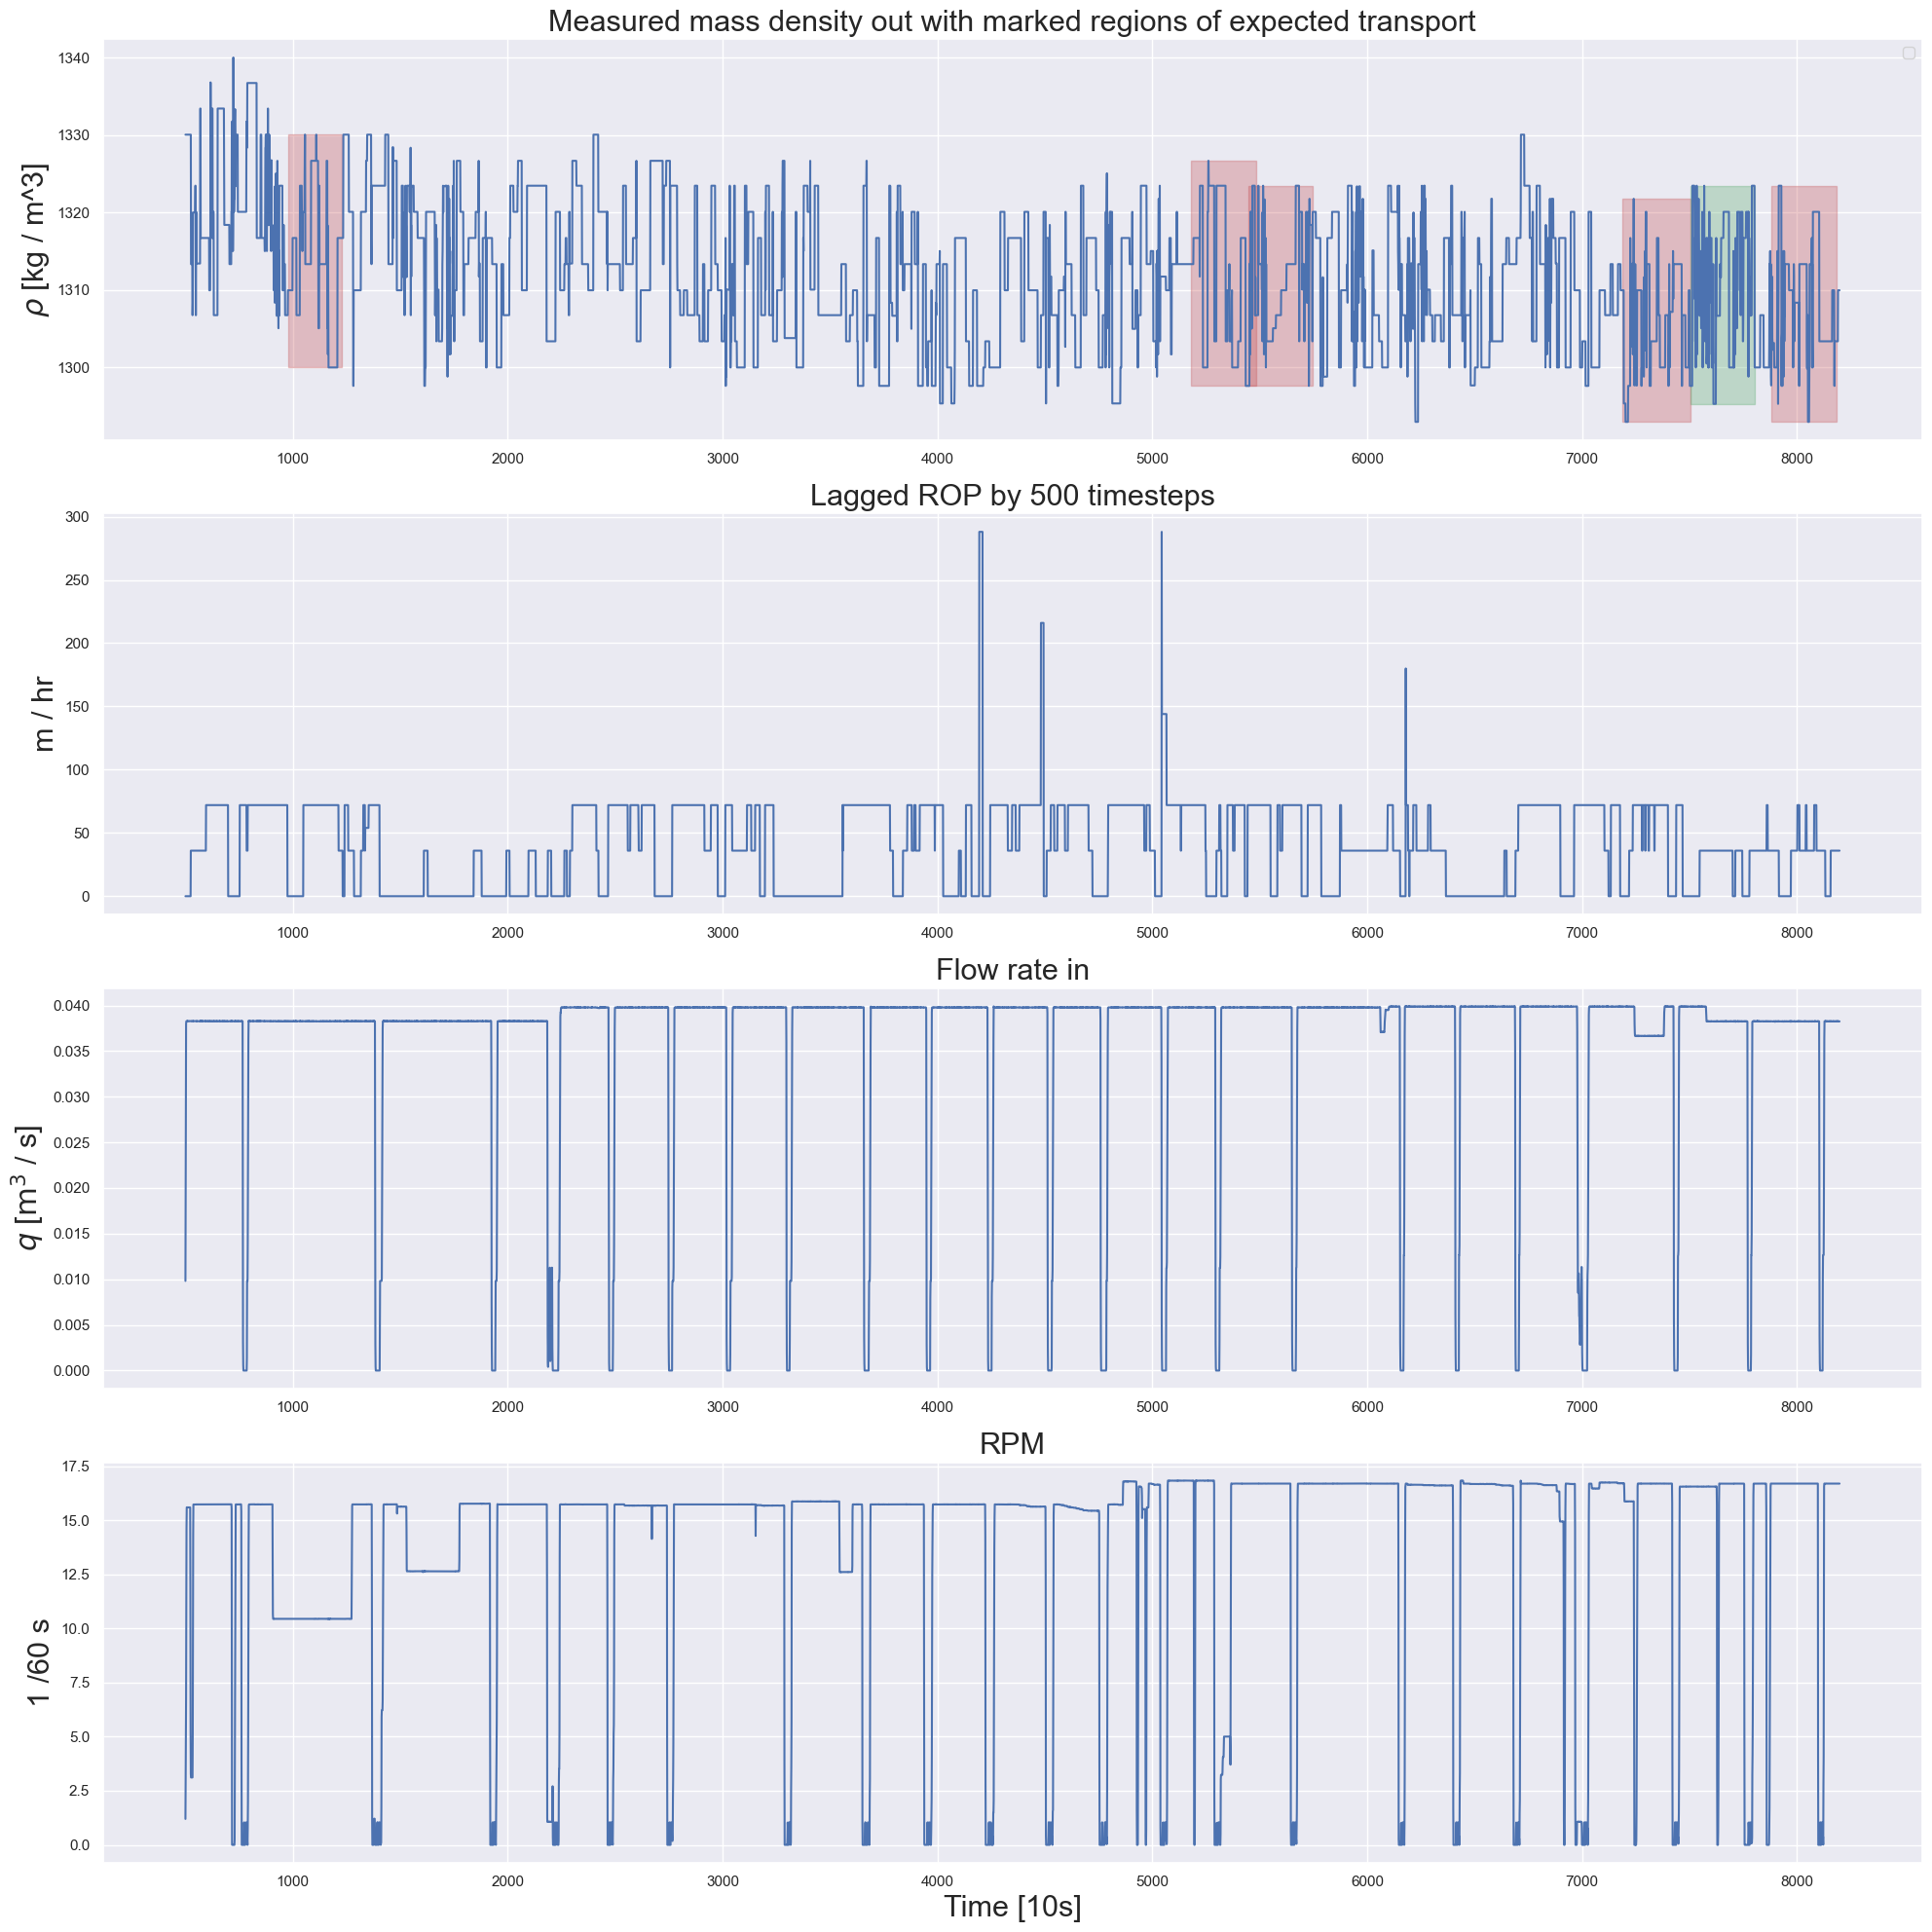

In [55]:
# filtered_mud_density_out = sc.ndimage.uniform_filter1d(df_sensor["MUD_DENS_OUT"].values, size = horizon_for_correlation - start_time)
mud_density_out = df_sensor["MUD_DENS_OUT"].values
# Removing some outliers as they are unlikely. Maybe some formation gas or things like that causes it. It is not relevant for our analysis.
colors = ["C1",  "C3"]
mud_density_out[1393:1430] = np.array([mud_density_out[1392] for _ in range(1393,1430)])
mud_density_out[2482:2523] = np.array([mud_density_out[2481] for _ in range(2482,2523)])
fig,ax = plt.subplots(4, figsize = (20,20))
ax[0].set_title("Measured mass density out with marked regions of expected transport",fontsize = 22)
ax[0].set_ylabel(r"$\rho$ [kg / m^3]",fontsize = 22)
ax[0].plot(x_values,mud_density_out[lower_bound:upper_bound])
ax[0].legend()
for idx,indice in enumerate(transport_times_dict.keys()):
    if indice == 7258:
        color = "C2"
    else:
        color = "C3"
    transport_times = transport_times_dict[indice]
    transport_region = np.arange(indice + transport_times[0], indice + transport_times[-1], 1)
    maximum_mud_density = np.max(mud_density_out[transport_region])
    minimum_mud_density = np.min(mud_density_out[transport_region])
    ax[0].fill_between(transport_region, minimum_mud_density, maximum_mud_density, color = color, alpha = 0.3, label = "Region of expected transport after transient")
ax[1].set_title(f"Lagged ROP by {lower_bound} timesteps",fontsize = 22)
ax[1].plot(x_values,[value * 3600 if  value != 0 else 0 for value in df_sensor["ropav"].iloc[:upper_bound-lower_bound].values ])
ax[1].set_ylabel("m / hr",fontsize = 22)

ax[2].set_title("Flow rate in",fontsize = 22)
ax[2].plot(x_values,df_sensor["MUD_FLOW_IN"].iloc[lower_bound:upper_bound].values)
ax[2].set_ylabel(r"$q$ [$\mathrm{m}^3$ / s]",fontsize = 22)

ax[3].set_title("RPM",fontsize = 22)
ax[3].plot(x_values,df_sensor["rpmav"].iloc[lower_bound:upper_bound].values)
ax[3].set_xlabel("Time [10s]",fontsize = 22)
ax[3].set_ylabel("1 /60 s",fontsize = 22)
plt.tight_layout()
plt.show()

In [30]:
# lower_bound_mass_density = 4935 + transport_times_dict[4935][0]
# upper_bound_mass_density = 5201 + transport_times_dict[5201][-1]
# interval_length = upper_bound_mass_density - lower_bound_mass_density
# x_interval = np.arange(lower_bound_mass_density -interval_length, upper_bound_mass_density,1)
# print(x_interval)
# fig, ax = plt.subplots(1, figsize = (20,10))
# ax.set_title("Measured mass density out")
# ax.set_xlabel("Time [10s]")
# ax.set_ylabel(r"$\rho$ [$\mathrm{gcm}^3$]")
# ax.plot(x_interval,mud_density_out[lower_bound_mass_density - interval_length:lower_bound_mass_density + interval_length])
# ax.axvline(x=interval_length + x_interval[0], color = "C2", linewidth = 3)

# # ax[1].set_title("Flow rate in")
# # ax[1].plot(df_sensor["MUD_FLOW_IN"].iloc[lower_bound_mass_density-interval_length:lower_bound_mass_density+interval_length].values)
# # ax[1].set_xlabel("Time [10s]")
# # ax[1].set_ylabel(r"$q$ [$\mathrm{m}^3$ / s]")

# # ax[1].set_title("RPM")
# # ax[1].plot(df_sensor["rpmav"].iloc[lower_bound_mass_density-interval_length:lower_bound_mass_density+interval_length].values)
# # ax[1].set_xlabel("Time [10s]")
# # ax[1].set_ylabel("1 /60 s")

# # ax[3].set_title("ROP")
# # ax[3].plot(df_sensor["ropav"].iloc[lower_bound_mass_density-interval_length-600:lower_bound_mass_density + interval_length-600].values)
# # ax[3].set_xlabel("Time [10s]")
# # ax[3].set_ylabel("m / hr")
# plt.show()
# rop_mean_region_one = np.mean(df_sensor["ropav"].iloc[lower_bound_mass_density-interval_length-600:lower_bound_mass_density-600].values)
# rop_mean_region_two = np.mean(df_sensor["ropav"].iloc[lower_bound_mass_density-interval_length-600:lower_bound_mass_density-600].values)


In [31]:
# rop_mean_region_one = np.mean(df_sensor["ropav"].iloc[lower_bound_mass_density-interval_length-570:lower_bound_mass_density-570].values)
# rop_mean_region_two = np.mean(df_sensor["ropav"].iloc[lower_bound_mass_density-570:upper_bound_mass_density+interval_length-570].values)
# print(rop_mean_region_one,rop_mean_region_two)
# density_region_one = mud_density_out[lower_bound_mass_density-interval_length:lower_bound_mass_density]
# density_region_two = mud_density_out[lower_bound_mass_density:upper_bound_mass_density+interval_length]

In [32]:
# stats.probplot(density_region_one)
# plt.show()
# stats.probplot(density_region_two)
# plt.show()

In [33]:
# test_statistic, p_value = stats.ttest_ind(density_region_two, density_region_one, alternative="greater")
# print(np.mean(density_region_one), np.mean(density_region_two))
# print(p_value)
# if p_value < 0.05:
#     print("The difference in mean is statistically significant")
# else:
#     print("you suck")


In [34]:
# time_start = 7238
# time_end = 7500
# delta_ecd = df_sensor["ASMECD1-T"].values - df_sensor["ASMECD2-T"].values
# delta_ecd_sim = df_simulated["ecdAtPos2"].values - df_simulated["ecdAtPos3"].values
# corresponding_flow = df_sensor["flowinav"].values
# corresponding_rpm = df_sensor["rpmav"].values
# corresponding_bit_depth = df_sensor["DEPTH_BIT"].values
# fig, ax = plt.subplots(4,figsize = (20,10))
# ax[0].plot(delta_ecd[time_start:time_end],label = "ASM")
# ax[0].plot(delta_ecd_sim[time_start:time_end], label = "HFM")
# ax[0].set_xlabel("time [10s]")
# ax[0].set_ylabel(r"$\Delta ECD$ $\mathrm{gcm}^{-3}$")
# ax[0].legend()

# ax[1].plot(corresponding_flow[time_start:time_end])
# ax[1].plot(corresponding_flow[time_start:time_end])
# ax[1].set_xlabel("time [10s]")
# ax[1].set_ylabel(r"$q$ $\mathrm{m}^3$ / s")

# ax[2].plot(corresponding_rpm[time_start:time_end])
# ax[2].plot(corresponding_rpm[time_start:time_end])
# ax[2].set_xlabel("time [10s]")
# ax[2].set_ylabel(r"RPM")

# ax[3].plot(corresponding_bit_depth[time_start:time_end])
# ax[3].plot(corresponding_bit_depth[time_start:time_end])
# ax[3].set_xlabel("time [10s]")
# ax[3].set_ylabel(r"Bit depth [m]")
# plt.tight_layout()
# plt.show()

In [35]:
for segment_ecd_1, segment_ecd_2, segment_ecd_1_sim, segment_ecd_2_sim,segment_flow,segment_torque, segment_hookload,segment_rpm,segment_bit_depth,segment_hole_depth, transient in zip(ecd_1_segments, ecd_2_segments, ecd_1_segments_sim, ecd_2_segments_sim,flow_segment,torque_segment,hookload_segment,rpm_segment,bit_depth_segment,hole_depth_segment, transients):
    fig,ax = plt.subplots(8, figsize = (20,30))
    fig.suptitle(f"Transient segment around timestamp {transient[0][10:19]} with index {transient[1]}", fontsize = 30)
    ax[0].plot(segment_ecd_1, label = "ASM 1")
    ax[0].plot(segment_ecd_1_sim, label = "HFM 1")
    ax[0].plot(segment_ecd_2, label = "ASM 2")
    ax[0].plot(segment_ecd_2_sim, label = "HFM 2")
    ax[0].set_ylabel(r'$ECD$ [$\text{gcm}^{-3}$]',fontsize = 26)
    ax[0].legend()

    ax[1].plot(segment_ecd_1 - segment_ecd_2, label = "ASM")
    ax[1].plot(segment_ecd_1_sim - segment_ecd_2_sim, label = "HFM")
    ax[1].set_ylabel(r'$\Delta ECD$ [$\text{gcm}^{-3}$]',fontsize = 26)
    ax[1].legend()


    ax[2].plot(segment_flow)
    ax[2].set_ylabel("$q$ [m^3 / kg]",fontsize = 26)
    ax[3].plot(segment_rpm)
    ax[3].set_ylabel("RPM [1/60 s]",fontsize = 26)
    ax[4].plot(segment_torque)
    ax[4].set_ylabel("$T$ [Nm]",fontsize = 26)
    ax[5].plot(segment_hookload)
    ax[5].set_ylabel("$HL$ [N]",fontsize = 26)
    ax[6].invert_yaxis()
    ax[6].plot(segment_bit_depth)
    ax[6].set_ylabel("$BD$ [m]",fontsize = 26)
    ax[7].invert_yaxis()
    ax[7].plot(segment_hole_depth)
    ax[7].set_ylabel("$HD$ [m]",fontsize = 26)
    ax[7].set_xlabel('Time [10s]',fontsize = 26)
    plt.tight_layout()
    plt.show()
    

In [36]:
# plot_with_warnings_pack_off_sensor_1_2(df_input=df_sensor, df_sim = df_simulated, warnings = transients,chunk_size=500)